In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import collections
import os
from google.cloud import vision

In [4]:
#pdf = pd.read_pickle("data_opioid_mul.pickle")
#pdf

In [6]:
df = pd.read_csv('Non_opioid_multi_Img.csv')

labellist = df['Set-ID']
#print (len(labellist))

counter=collections.Counter(labellist)
print (len(counter))
#for key, value in counter.items() :
#    print (key, value)
new = {key: value for key, value in counter.items() if value > 1 and value < 6}
print (len(new))
count_fre = collections.Counter(counter.values())
newdf = pd.DataFrame(list(zip(count_fre.keys(),count_fre.values())), 
               columns =['Name', 'val']) 
newdf.to_csv('Non_opioid_counter.csv')

14298
12854


In [40]:
final_list = new.keys()
df = df[df['Set-ID'].isin(final_list)]
df.to_csv('new_opioid_multi_Img.csv')

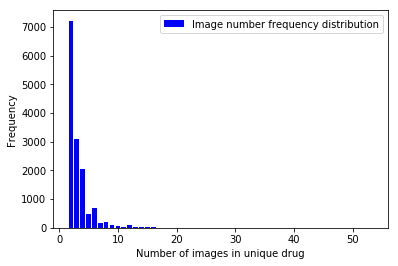

In [27]:
plt.bar(count_fre.keys(),count_fre.values(), label="Image number frequency distribution",
       color='b')
plt.legend()
plt.xlabel('Number of images in unique drug')
plt.ylabel('Frequency')
plt.show()